<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Общая-выборка" data-toc-modified-id="Общая-выборка-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Общая выборка</a></span></li><li><span><a href="#Выборка-за-месяц" data-toc-modified-id="Выборка-за-месяц-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Выборка за месяц</a></span></li><li><span><a href="#Неделя" data-toc-modified-id="Неделя-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Неделя</a></span></li><li><span><a href="#День" data-toc-modified-id="День-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>День</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Light-Gradient-Boosted-Machine-(LightGBM)" data-toc-modified-id="Light-Gradient-Boosted-Machine-(LightGBM)-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Light Gradient Boosted Machine (LightGBM)</a></span></li><li><span><a href="#CatBoost-Regressor" data-toc-modified-id="CatBoost-Regressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoost Regressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [4]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
data.shape

(26496, 1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
data.isnull().sum()

num_orders    0
dtype: int64

In [9]:
data.duplicated().sum()

26415

Есть дупликаты, но в этом случае они могут быть и не помешают дальнейшему анализу и обучению моделей.

## Анализ

### Общая выборка

In [10]:
data = data.resample('1H').sum()

In [11]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [12]:
def graphics (data):
    data.plot(figsize=(20,10))
    plt.title('Количество заказов за период', fontsize=20)
    plt.xlabel('Время заказа', fontsize=16)
    plt.ylabel('Количество заказов', fontsize=16)
    plt.show()

In [13]:
def decomp (data):
    decomposed_data = seasonal_decompose(data)
    
    plt.figure(figsize=(20, 30))

    plt.subplot(311)
    decomposed_data.trend.plot(ax=plt.gca())
    plt.title('Тренд', fontsize=20)
    plt.xlabel('Время заказа', fontsize=16)
    plt.ylabel('Количество заказов', fontsize=16)
    
    plt.subplot(312)
    decomposed_data.seasonal.plot(ax=plt.gca())
    plt.title('Сезонная составляющая', fontsize=20)
    plt.xlabel('Время заказа', fontsize=16)
    plt.ylabel('Количество заказов', fontsize=16)
    
    plt.subplot(313)
    decomposed_data.resid.plot(ax=plt.gca())
    plt.title('Остаток декомпозиции', fontsize=20)
    plt.xlabel('Время заказа', fontsize=16)
    plt.ylabel('Количество заказов', fontsize=16)

Посмотрим на графике наши данные

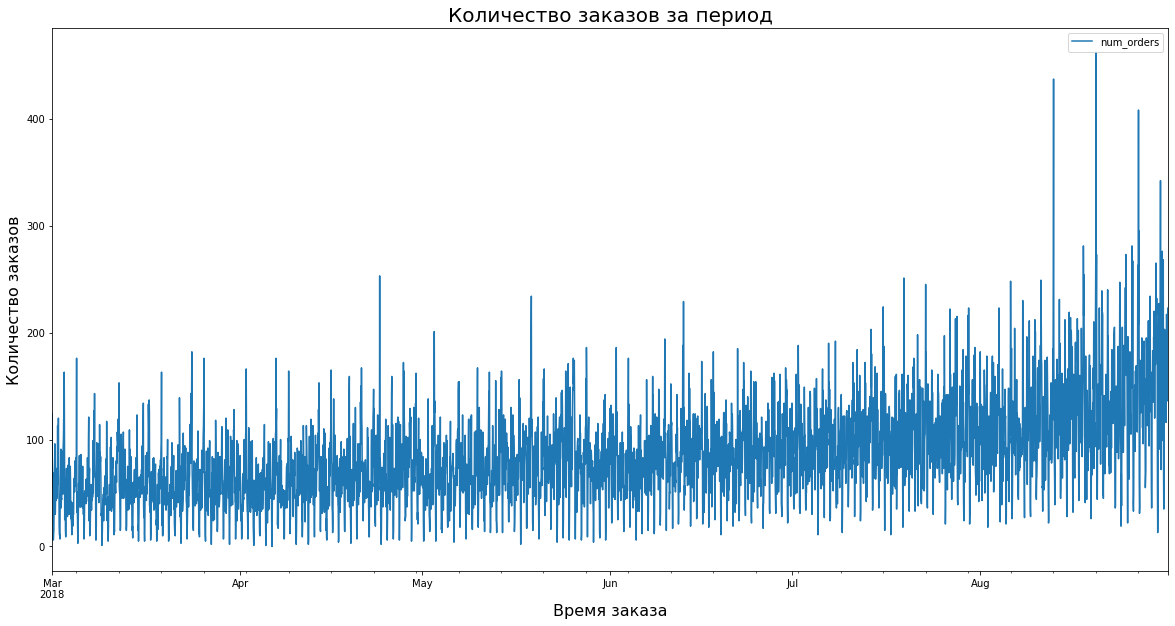

In [14]:
graphics(data)

Добавим скользящее среднее

In [15]:
data_roll = data.copy()
data_roll['rolling_mean'] = data_roll.rolling(70).mean()

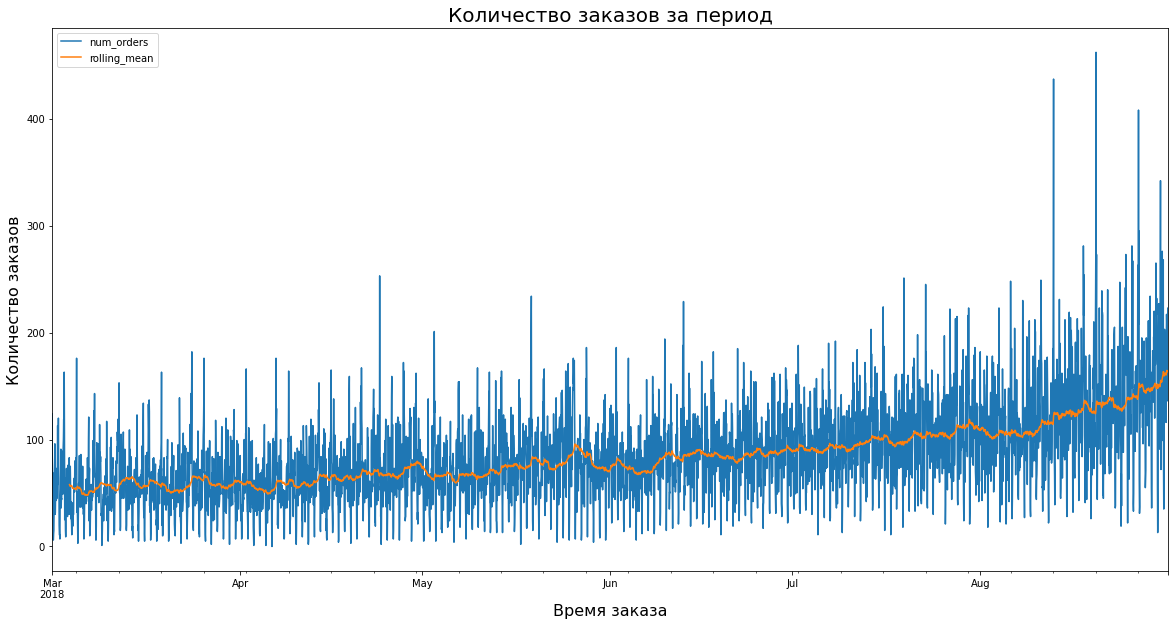

In [16]:
graphics(data_roll)

Декомпозируем данные и изучим сезонность и тренды

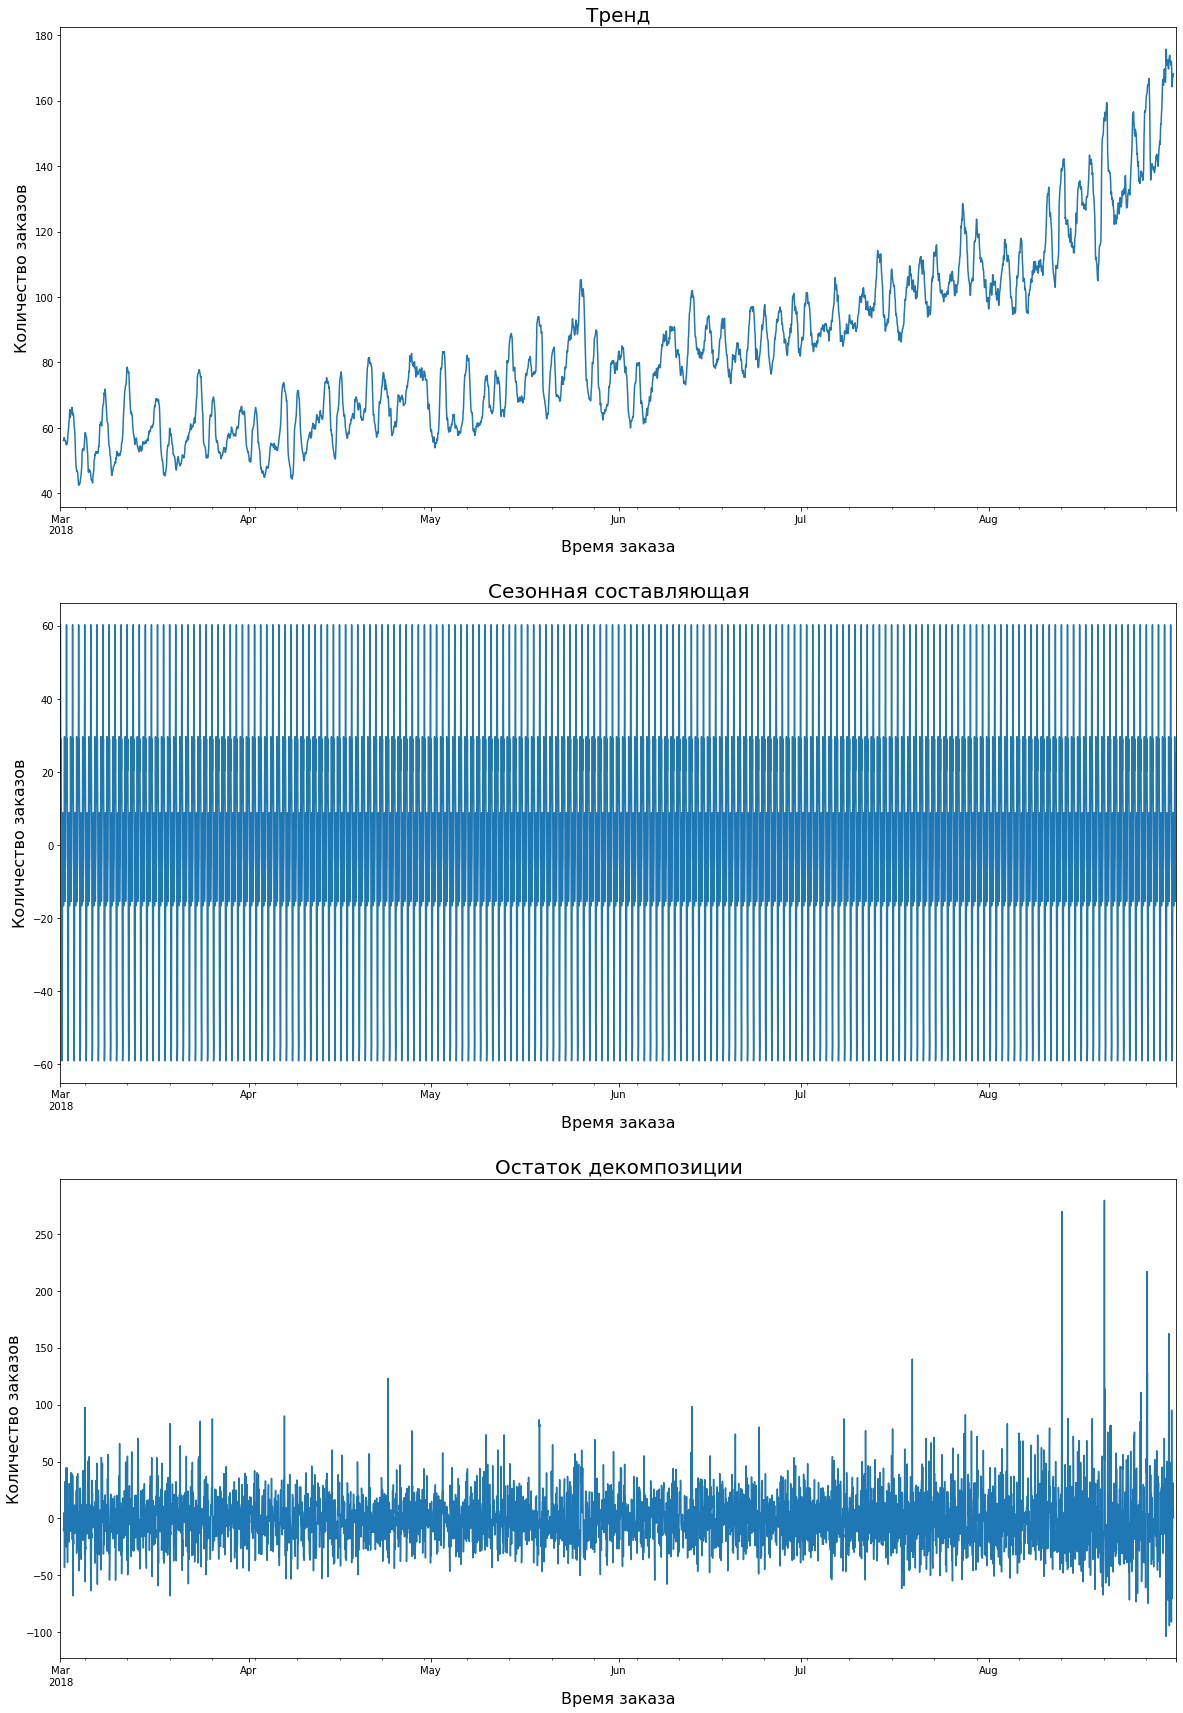

In [17]:
decomp(data)

Попробуем уменьшить выборку и посмотреть данные

### Выборка за месяц

In [18]:
data_month = data['2018-08-01' : '2018-08-31']

In [19]:
data_month_roll = data_month.copy()
data_month_roll['rolling_mean'] = data_month.rolling(70).mean()

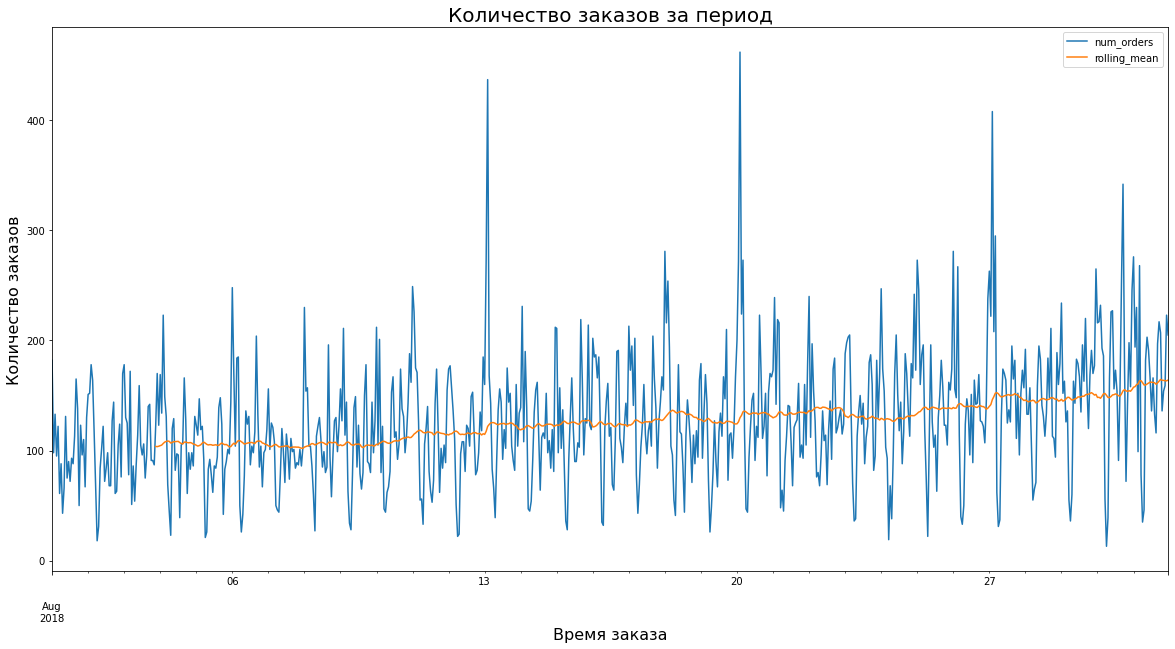

In [20]:
graphics(data_month_roll)

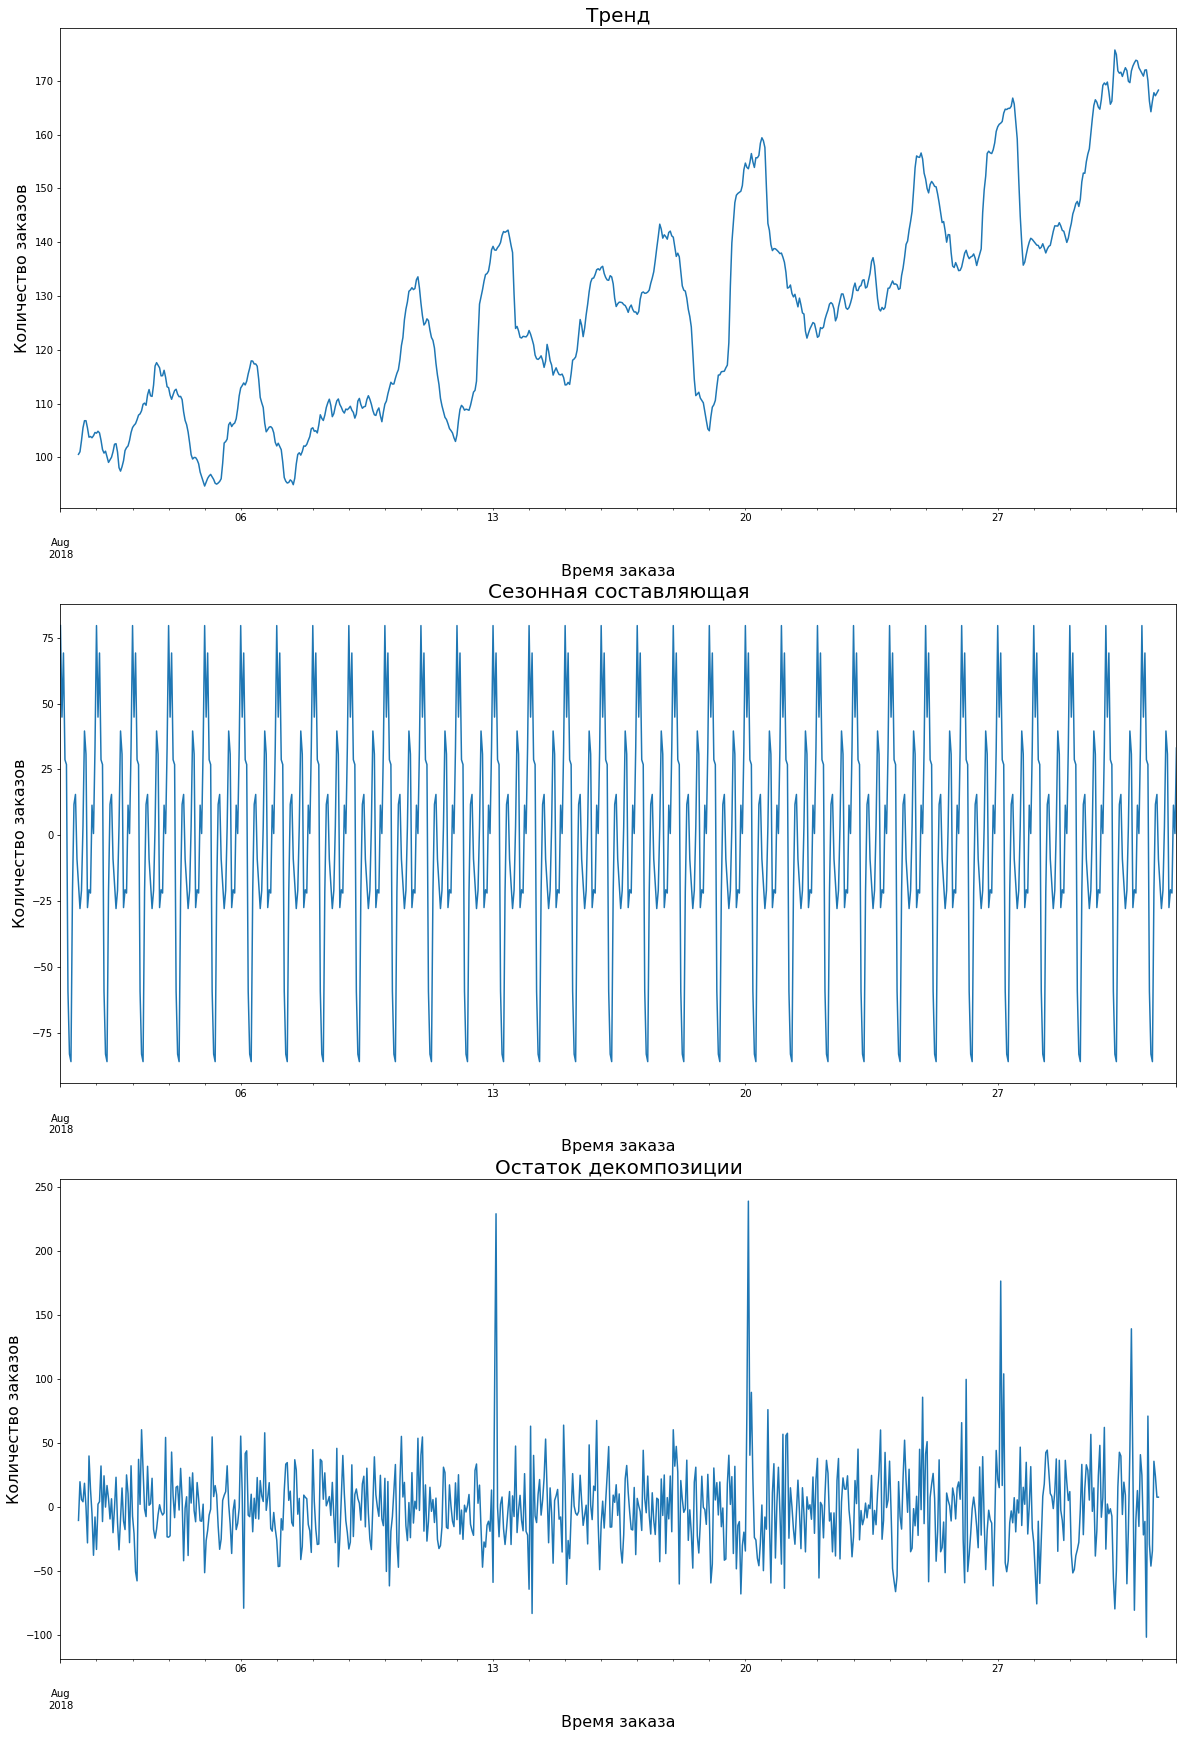

In [21]:
decomp(data_month)

### Неделя

In [22]:
data_weak = data['2018-08-25':'2018-08-31']

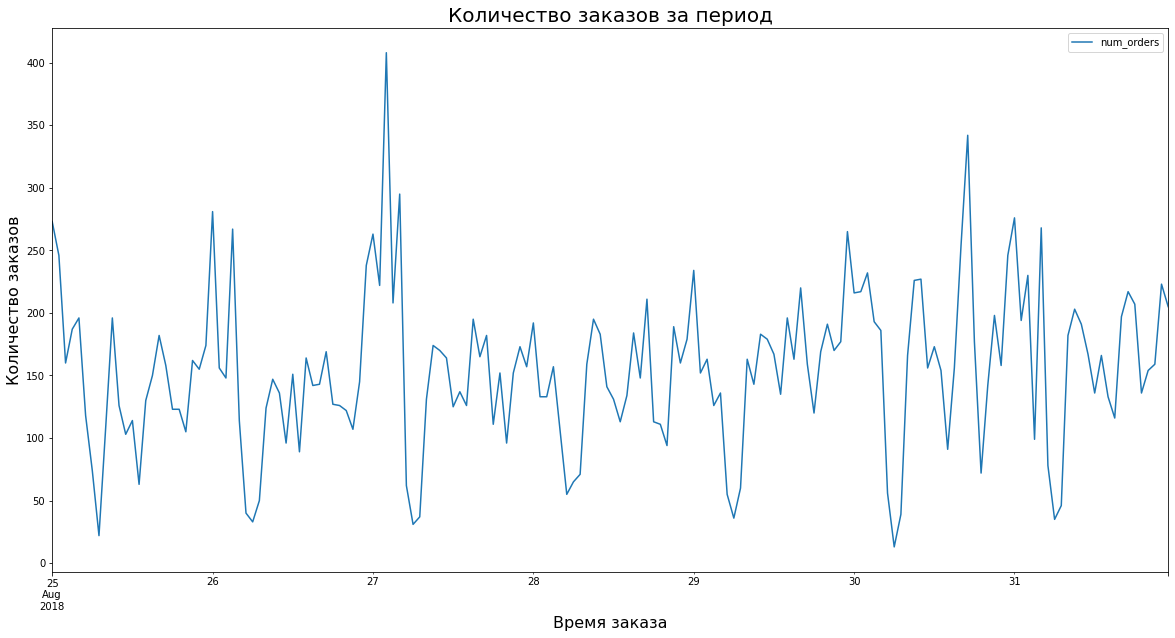

In [23]:
graphics(data_weak)

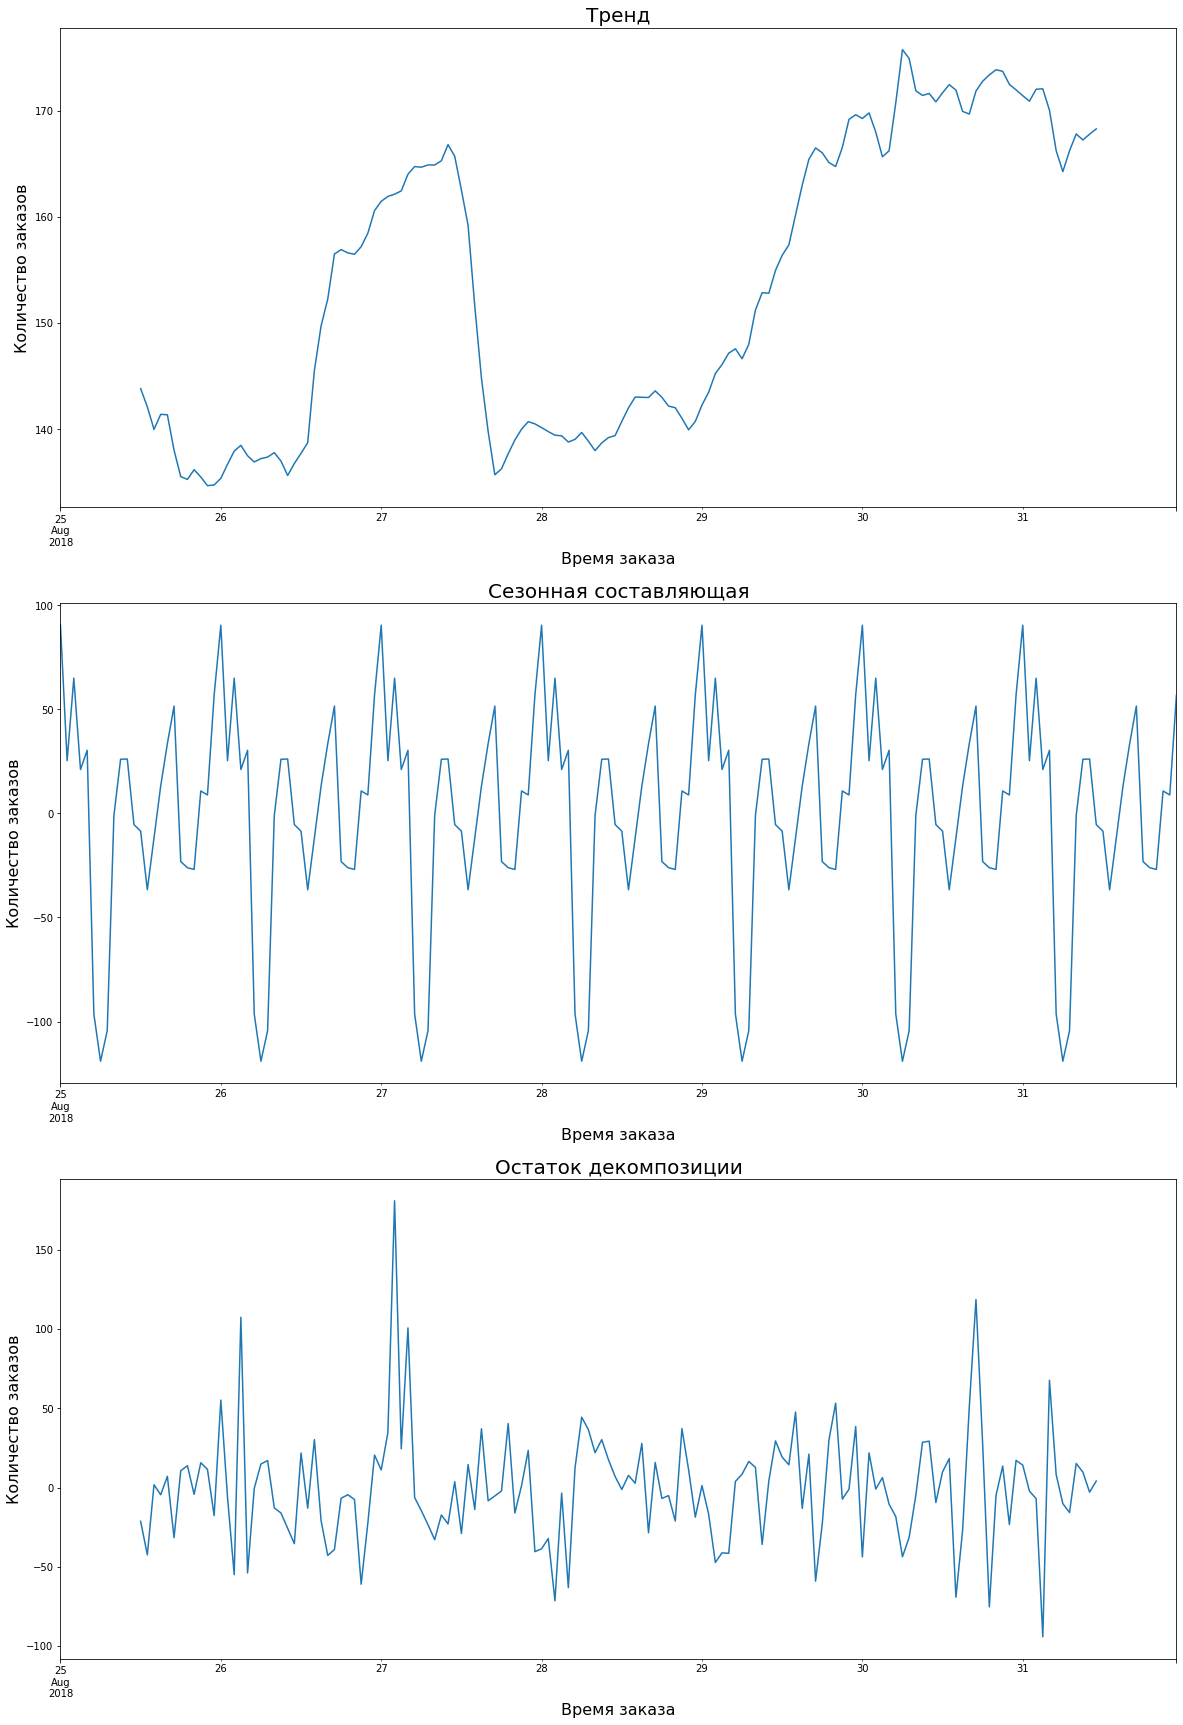

In [24]:
decomp(data_weak)

### День

In [25]:
data_day = data['2018-08-30':'2018-08-31']

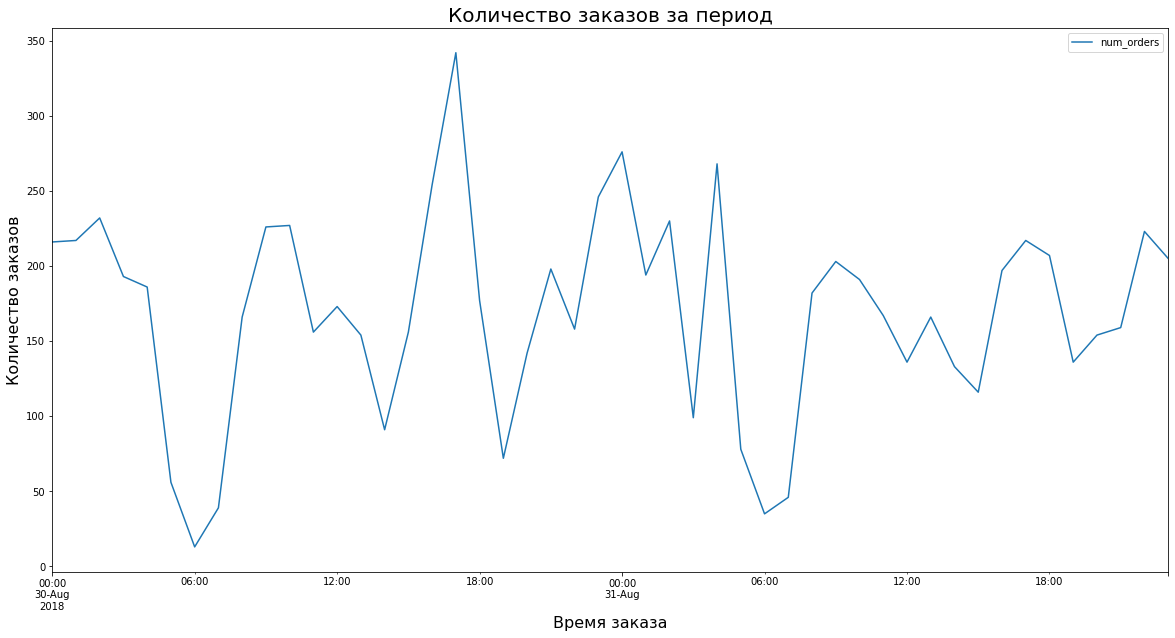

In [26]:
graphics(data_day)

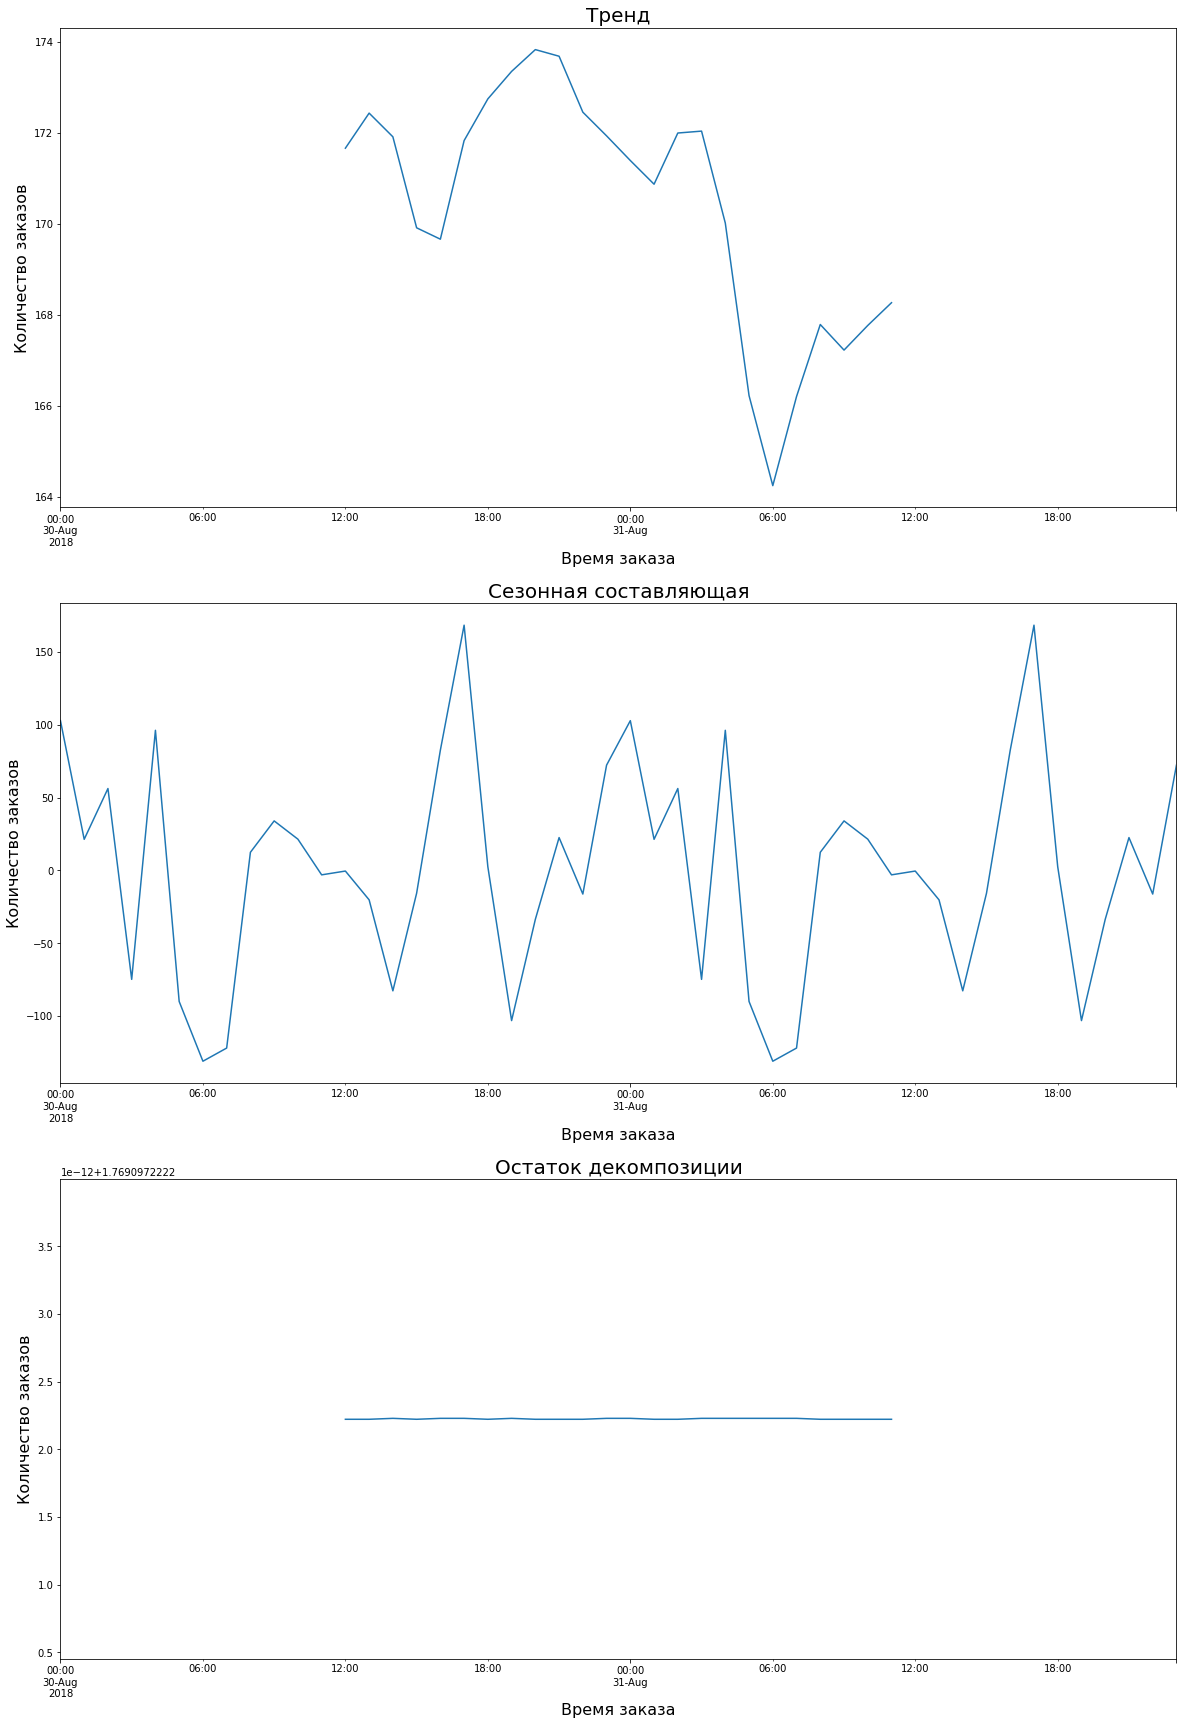

In [27]:
decomp(data_day)

### Вывод

- Дисперсия увеличичвается
- Судя по графикам тренда, мы можем наблюдать с каждым месяцем увеличение заказов.
- Пики количества заказов приходятся на утро с 9-11, конец рабочего дня 15-18 и максимальне значение в районе полуночи, а также есть пик в 5 утра
- Временной ряд является стационарным.

In [30]:
from statsmodels.tsa.stattools import adfuller

ts = data['num_orders']
st_test = adfuller(ts, regression='ctt')

print(f'p-value: {st_test[1]}')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

p-value: 4.0549397892403547e-17
Наш ряд стационарный


## Обучение

Создадим признаки для обучения модели

In [27]:
metrics_results = pd.DataFrame(columns=['RMSE_train'])

In [28]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)
    
    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [29]:
def metrics(model_name, RMSE_train):
    metrics_results.loc[model_name,'RMSE_train'] = RMSE_train
    metrics_results['Model'] = metrics_results.index
    return metrics_results

lag - примем за 24 часа
rolling_mean_size - примем за 48 часов

In [30]:
data_features = data.copy()

In [31]:
make_features(data_features,'num_orders', 24, 48)

In [32]:
data_features.head(50)

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
train, test = train_test_split(data_features, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [34]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(3926, 28)
(3926,)
(442, 28)
(442,)


In [35]:
n_splits = len(train)/len(test)
n_splits

8.882352941176471

Примем n_splits за 9

In [36]:
tscv = TimeSeriesSplit(n_splits=9)

### Линейная регрессия

In [37]:
model_LR = LinearRegression()
cv_model_LR = (cross_val_score(model_LR,
                               features_train,
                               target_train, 
                               cv=tscv, 
                               scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print("Метрика RMSE Линейной регресии с использованием Прямого кодирования:", cv_model_LR)
metrics('LinearRegression',cv_model_LR)

Метрика RMSE Линейной регресии с использованием Прямого кодирования: 26.89148051877483


,RMSE_train,Model
LinearRegression,26.891481,LinearRegression


In [38]:
def gridi_train (model, regressor, parametrs, model_name):
    model = regressor(random_state=12345)
    model = GridSearchCV(model,
                      parametrs,
                      cv=tscv,
                      scoring='neg_mean_squared_error')
    model.fit(features_train, target_train)
    RMSE = (-model.best_score_) ** 0.5
    print('Показатель RMSE:', RMSE, 'при параметрах:', model.best_params_)
    metrics(model_name, RMSE)

### Дерево решений

In [41]:
parametrs_dr = {'max_depth': range(2, 30)}
gridi_train(DecisionTreeRegressor, parametrs_dr, 'DecisionTreeRegressor')

Показатель RMSE: 29.354965782166296 при параметрах: {'max_depth': 5}


### Случайный лес

In [42]:
parametrs_rf = [{'n_estimators': range(0, 40, 5),
               'max_depth': range(1, 15, 5)}]
gridi_train(RandomForestRegressor, parametrs_rf, 'RandomForestRegressor')

Показатель RMSE: 24.971274834213748 при параметрах: {'max_depth': 11, 'n_estimators': 35}


### Light Gradient Boosted Machine (LightGBM)

In [43]:
parametrs_lgbm = {'max_depth': [5,10],
                  "n_estimators": range (5, 15, 5),
                 'learning_rate': [0.1,0.4]}

gridi_train(LGBMRegressor, parametrs_lgbm, 'LGBMRegressor')

Показатель RMSE: 25.215984197488986 при параметрах: {'learning_rate': 0.4, 'max_depth': 10, 'n_estimators': 10}


### CatBoost Regressor

In [2]:
parametrs_cb = [{'clf__C': [0.1, 1, 10, 100],
    'learning_rate':[0.1, 0.5, 0.8],
                'verbose' : [250],
                'n_estimators' : [40, 80]}]

gridi_train(CatBoostRegressor, parametrs_cb, 'CatBoostRegressor')

NameError: name 'gridi_train' is not defined

In [45]:
metrics_results

,RMSE_train,Model
LinearRegression,26.891481,LinearRegression
DecisionTreeRegressor,29.354966,DecisionTreeRegressor
RandomForestRegressor,24.971275,RandomForestRegressor
LGBMRegressor,25.215984,LGBMRegressor
CatBoostRegressor,24.423186,CatBoostRegressor


Были построенны 5 моделей машинного обучения. Изучены метрики RMSE и время на предсказание моделей и сведены в общую таблицу

## Тестирование

Посмотрим на все полученные данные

In [46]:
metrics_results

,RMSE_train,Model
LinearRegression,26.891481,LinearRegression
DecisionTreeRegressor,29.354966,DecisionTreeRegressor
RandomForestRegressor,24.971275,RandomForestRegressor
LGBMRegressor,25.215984,LGBMRegressor
CatBoostRegressor,24.423186,CatBoostRegressor


Можем увидеть, что на обучающей выборке лучший результат показал CatBoostRegressor. Совсем немного уступает RandomForestRegressor. Поэтому модель будет тестировать на CatBoostRegressor

In [47]:
def gridi_test (regressor, parametrs):
    model = CatBoostRegressor(random_state=12345)
    model = GridSearchCV(model,
                      parametrs,
                      cv=tscv,
                      scoring='neg_mean_squared_error')
    model.fit(features_test, target_test)
    RMSE = (-model.best_score_) ** 0.5
    print('Показатель RMSE:', RMSE)

In [48]:
parametrs_cb_test = [{'learning_rate':[0.1], 'n_estimators': [80], 'verbose': [250]}]

gridi_test(CatBoostRegressor, parametrs_cb_test)

0:	learn: 43.8598075	total: 1.31ms	remaining: 104ms
79:	learn: 4.3394624	total: 77ms	remaining: 0us
0:	learn: 46.0916153	total: 1.96ms	remaining: 155ms
79:	learn: 7.5342990	total: 131ms	remaining: 0us
0:	learn: 46.6956856	total: 2.59ms	remaining: 204ms
79:	learn: 11.2524314	total: 161ms	remaining: 0us
0:	learn: 54.3157340	total: 3.15ms	remaining: 249ms
79:	learn: 16.4353626	total: 199ms	remaining: 0us
0:	learn: 53.0337214	total: 3.48ms	remaining: 275ms
79:	learn: 17.3385052	total: 227ms	remaining: 0us
0:	learn: 52.2991853	total: 3.83ms	remaining: 302ms
79:	learn: 19.9071666	total: 264ms	remaining: 0us
0:	learn: 53.0772321	total: 4.04ms	remaining: 319ms
79:	learn: 18.8594101	total: 287ms	remaining: 0us
0:	learn: 54.6901252	total: 4.47ms	remaining: 353ms
79:	learn: 20.1020403	total: 305ms	remaining: 0us
0:	learn: 54.2310282	total: 4.32ms	remaining: 341ms
79:	learn: 20.1947861	total: 337ms	remaining: 0us
0:	learn: 56.3654915	total: 5.36ms	remaining: 424ms
79:	learn: 22.7903675	total: 423m

## Вывод

В ходе работы было выполнено:
- Предобработка данных:
    - Произведена загрузка данных и их последующее ресемплирование по одному часу;
    - Определена сезонность и тренд данных;
- Обучение:
    - Построены 5 моделей машинного улучшения для выявления самого подходящего метода.
    - С использованием лучшей модели и лучших гиперпараметров, на тренировочной выборке была найдена метрика RMSE
По итогам построения моделей, была выявлена лучшая для тестовой выборки: CatBoostRegressor (Показатель метрики RMSE = 42.4975)